In [12]:
%%file csplitoper_impl.c
#include <string.h>
#include "csplitoper.h"

#ifndef M_PI
#define M_PI (3.14159265358979323846264338327950288)
#endif

splitoper_state *splitoper_init(
  double complex *v, double complex *phi, size_t n, double L, double tmax) {

  splitoper_state *state = malloc(sizeof(splitoper_state));

  /* Allocate space */
  state->v = fftw_alloc_complex(n);
  state->phi = fftw_alloc_complex(n);

  /* Initialize variables */
  state->L = L;
  state->dt = tmax / (n - 1.0);
  state->t = 0;

  state->n = n;

  state->fwd_plan = fftw_plan_dft_1d(
    n, state->phi, state->phi,
    FFTW_FORWARD, FFTW_ESTIMATE
  );

  state->rev_plan = fftw_plan_dft_1d(
    n, state->phi, state->phi,
    FFTW_BACKWARD, FFTW_ESTIMATE
  );

  memcpy(state->v,   v,   n*sizeof(double complex));
  memcpy(state->phi, phi, n*sizeof(double complex));

  return state;
}

void splitoper_destroy(splitoper_state *state) {
  if (state != NULL) {
    fftw_destroy_plan(state->fwd_plan);
    fftw_destroy_plan(state->rev_plan);

    fftw_free(state->v);
    fftw_free(state->phi);

    free(state);
  }
}


void splitoper_step(splitoper_state *state) {
  int32_t idx;
  double kx;

  double L = state->L;
  double dt = state->dt;
  int32_t n = state->n;

  //	Begin 1st kinetic energy halfstep
  fftw_execute_dft(state->fwd_plan, state->phi, state->phi);

  // FFTW has zero-frequency component at first component
  for (idx = 0; idx < n; idx++) {
    if (idx <= n/2)
      kx = idx * 2.0 * M_PI / L;
    else
      kx = (idx - state->n) * 2.0 * M_PI / L;

    state->phi[idx] *= cexp(-I * 0.5 * dt * kx * kx);
  }

  fftw_execute_dft(state->rev_plan, state->phi, state->phi);
  for (idx = 0; idx < n; idx++){
    state->phi[idx] /= ((double)n);
  }

  // End 1st kinetic energy fullstep



  // Potential energy fullstep
  for (idx = 0; idx < n; idx++){
    state->phi[idx] *= cexp(-I * dt * state->v[idx]);
  }


  //	Begin 2nd kinetic energy halfstep
  fftw_execute_dft(state->fwd_plan, state->phi, state->phi);

  // FFTW has zero-frequency component at first component,
  // documentation: positive frequencies are stored in the first half of the
  // output, negative frequencies are stored in backwards order in the second
  // half of the output
  // The frequency -k/n is the same as the frequency (n-k)/n
  for (idx = 0; idx < n; idx++) {
    if (idx <= n/2)
      kx = idx * 2.0 * M_PI / L;
    else
      kx = (idx - state->n) * 2.0 * M_PI / L;

    state->phi[idx] *= cexp(-I * 0.5 * dt * kx * kx);
  }

  fftw_execute_dft(state->rev_plan, state->phi, state->phi);
  for (idx = 0; idx < n; idx++){
    state->phi[idx] /= ((double)n);
  }

  //	End 2nd kinetic energy halfstep

  // advance time
  state->t += dt;
}

double complex *splitoper_getwavefunction(splitoper_state *state) {
  return(state->phi);
}


Writing csplitoper_impl.c


In [13]:
%%file csplitoper.h
#ifndef CSPLITOPER_H
#define CSPLITOPER_H

#include <complex.h>
#include <math.h>
#include <stdlib.h>
#include <stdint.h>

/* Order matters! */
#include <fftw3.h>

typedef struct {
  int32_t n;

  fftw_plan fwd_plan;
  fftw_plan rev_plan;

  double complex *v;
  double complex *phi;

  double L;
  double dt;
  double t;
} splitoper_state;

splitoper_state *splitoper_init(double complex *v, double complex *phi, size_t n, double L, double tmax);
void splitoper_destroy(splitoper_state *state);

double complex *splitoper_getwavefunction(splitoper_state *state);

void splitoper_step(splitoper_state *state);

#endif /* end of include guard: CSPLITOPER_H */


Overwriting csplitoper.h


In [14]:
%%file csplitoper.pxd
cdef extern from "csplitoper.h":
  ctypedef struct splitoper_state:
    pass

  splitoper_state *splitoper_init(double complex *v, double complex *phi, size_t n, double L, double tmax)
  void splitoper_destroy(splitoper_state *state)
  void splitoper_step(splitoper_state *state)

  double complex *splitoper_getwavefunction(splitoper_state *state);


Overwriting csplitoper.pxd


In [15]:
%%file splitoper.pyx
cimport csplitoper
import numpy as np
cimport numpy as np

cdef class Splitoperator:
  cdef csplitoper.splitoper_state* state
  cdef np.npy_int32 n

  def __cinit__(self,
                np.ndarray[np.complex128_t, ndim=1] v,
                np.ndarray[np.complex128_t, ndim=1] phi,
                double L, double tmax):
    if v is None:
      raise ValueError("Input array v cannot be None")

    if phi is None:
      raise ValueError("Input array phi cannot be None")

    if len(v) != len(phi):
      raise ValueError("Need same size input arrays")

    self.n = len(v)
    self.state = csplitoper.splitoper_init(<double complex *>v.data, <double complex *>phi.data, self.n, L, tmax)


  def __dealloc__(self):
    if self.state is not NULL:
      csplitoper.splitoper_destroy(self.state)


  cpdef step(self):
    csplitoper.splitoper_step(self.state)


  cpdef get_wavefunction(self):
    cdef double complex* c_pointer
    cdef np.complex128_t[:] view

    c_pointer = csplitoper.splitoper_getwavefunction(self.state)

    view = np.asarray(<np.complex128_t[:self.n]> c_pointer)

    return view


Overwriting splitoper.pyx


In [16]:
%%file setup.py
from distutils.core import setup
from distutils.extension import Extension

from Cython.Build import cythonize
import numpy


setup(
    ext_modules = cythonize([
        Extension("splitoper", ["splitoper.pyx", "csplitoper_impl.c"], libraries=["fftw3"],
        extra_compile_args=["--std=c99"],
        include_dirs=[numpy.get_include()])
    ])
)


Overwriting setup.py


In [17]:
%run setup.py build_ext -i

running build_ext
building 'splitoper' extension
gcc -pthread -B /home/nbuser/anaconda3_501/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I. -I/home/nbuser/anaconda3_501/lib/python3.6/site-packages/numpy/core/include -I/home/nbuser/anaconda3_501/include/python3.6m -c splitoper.c -o build/temp.linux-x86_64-3.6/splitoper.o --std=c99


SystemExit: error: command 'gcc' failed with exit status 1

In [8]:
%matplotlib inline

import matplotlib.pylab as pl
import numpy
import matplotlib.animation as animation
from matplotlib import rc

from splitoper import Splitoperator

rc('animation', html='html5')

In [9]:
class QW(object):
    def __init__(self, ax):
        self.n = 2**14
        x0 = 50
        sigma = 0.25

        Vc = 5000;

        L = 100

        self.a = numpy.zeros(self.n,dtype=numpy.complex128)
        x = numpy.linspace(0,L,self.n)

        self.a = self.a + Vc * 38 * (
            (numpy.exp((x-20)) + numpy.exp(-(x-20)))**(-2) +  (numpy.exp((x-80)) + numpy.exp(-(x-80)))**(-2)
        )

        self.ax = ax

#        mask1 = numpy.logical_and(x >= 15, x <= 25)
#        mask2 = numpy.logical_and(x >= 75, x <= 85)
#        mask3 = numpy.logical_not(numpy.logical_or(mask1, mask2))

#        self.a[mask1] = 1e16
#        self.a[mask2] = -1e16
#        self.a[mask3] = 0

        # absorbing boundaries
        self.a = self.a + -2000j * (numpy.exp(-.5 * numpy.linspace(0,L,self.n)) + numpy.exp(.5 * numpy.linspace(-L,0,self.n)))


        # potential wells
        #self.a[4000:5000] = 5000000
#        self.a[10000:13000]= 5000

        speed = 0.98*numpy.sqrt(Vc)
        # initialize simulation
        phi = 1/numpy.sqrt(2 * numpy.pi * sigma) * \
            numpy.exp(1j * speed * numpy.pi * numpy.linspace(0,L,self.n)) * \
            numpy.exp(-(numpy.linspace(0,L,self.n)-x0)**2/(2*sigma)**2)

        self.sim = Splitoperator(self.a, phi, L, 6)

        self.phi2  = self.sim.get_wavefunction()
        self.line, = self.ax.plot(numpy.linspace(0,L,self.n), numpy.abs(phi)**2)

#        self.ax.set_ylim((-1,0.1))

        newax = self.ax.get_figure().add_axes(self.ax.get_position(), frameon=False)
        newax.yaxis.set_label_position('right')
        newax.yaxis.set_ticks_position('right')
        newax.xaxis.set_ticks_position('none')

        newax.plot(numpy.linspace(0,L,self.n), numpy.real(self.a), 'r')

        self.R = 0
        self.T = 0

    def init(self):
        return self.line,

    def __call__(self, i):
        self.sim.step()
        self.phi2 = self.sim.get_wavefunction()

        self.line.set_ydata(numpy.abs(self.phi2)**2)
        self.T += numpy.abs(self.phi2[self.n-1200])
        self.R += numpy.abs(self.phi2[1200])

        return self.line,

    

0 0


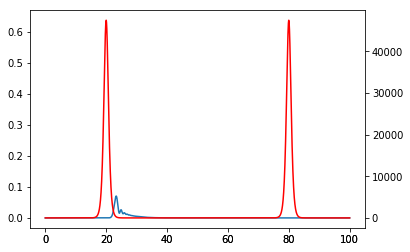

In [11]:
fig, ax = pl.subplots()

qw = QW(ax)

anim = animation.FuncAnimation(fig, qw, frames=3000, interval=20, init_func=qw.init)

print(qw.T,qw.R)
anim